## False-negative invariant EMD

This notebook is to showcase a few examples and properties of the false-negative invariant Earth Mover's Distance (EMD) versus the original formulation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from ot.lp import emd

# Helper functions
def sum_to_1(mat):
    total = np.sum(mat)
    return mat / total if total != 0 else mat

def importance_mass_accuracy(gt_mask, attribution):
    if attribution.ndim != 1 or len(gt_mask) != len(attribution):
        return np.nan
    abs_attr = np.abs(attribution)
    mass_in_gt = np.sum(abs_attr[gt_mask == 1])
    total_mass = np.sum(abs_attr)
    if total_mass == 0:
        return 1.0 if mass_in_gt == 0 else 0.0
    return mass_in_gt / total_mass

def create_cost_matrix(grid_edge_length):
    # Creates a cost matrix for a grid of grid_edge_length * grid_edge_length features
    if grid_edge_length == 0:
        return np.array([]).reshape(0,0)
    
    total_features = grid_edge_length * grid_edge_length
    if total_features == 1:
        return np.array([[0.0]])
        
    indices_matrix = np.indices((grid_edge_length, grid_edge_length))
    coordinates = []
    for r in range(grid_edge_length):
        for c in range(grid_edge_length):
            coordinates.append((indices_matrix[0][r, c], indices_matrix[1][r, c]))
    coordinates = np.array(coordinates)
    return cdist(coordinates, coordinates)



# def calculate_emd_score_metric(gt_mask_flat, attribution_flat, grid_edge_length, base_cost_matrix, is_fni=False):
#     # Input checks
#     if not (isinstance(gt_mask_flat, np.ndarray) and gt_mask_flat.ndim == 1 and
#             isinstance(attribution_flat, np.ndarray) and attribution_flat.ndim == 1 and
#             len(gt_mask_flat) == len(attribution_flat) and
#             len(gt_mask_flat) == grid_edge_length * grid_edge_length):
#         return np.nan

#     current_cost_matrix = np.copy(base_cost_matrix)
#     if is_fni:
#         gt_indices = np.where(gt_mask_flat == 1)[0]
#         for r_idx in gt_indices:
#             for c_idx in gt_indices:
#                 # Ensure indices are within bounds of the cost matrix
#                 if r_idx < current_cost_matrix.shape[0] and c_idx < current_cost_matrix.shape[1]:
#                     current_cost_matrix[r_idx, c_idx] = 0.0
    
#     sum_gt = np.sum(gt_mask_flat)
#     abs_attribution = np.abs(attribution_flat)
#     sum_attr = np.sum(abs_attribution)

#     if sum_gt < 1e-9 and sum_attr < 1e-9: # Effectively both empty
#         return 1.0
#     if sum_gt < 1e-9 or sum_attr < 1e-9: # One empty, other not
#         return 0.0
        
#     dist_gt = gt_mask_flat.astype(np.float64) / sum_gt
#     dist_attr = abs_attribution.astype(np.float64) / sum_attr
    
#     # Ensure distributions are C-contiguous and float64 for EMD
#     dist_gt_c = np.ascontiguousarray(dist_gt, dtype=np.float64)
#     dist_attr_c = np.ascontiguousarray(dist_attr, dtype=np.float64)
#     current_cost_matrix_c = np.ascontiguousarray(current_cost_matrix, dtype=np.float64)

#     cost_val = 0.0
#     if grid_edge_length * grid_edge_length > 1 : # EMD makes sense for >1 feature
#         try:
#             # Note: emd returns the cost value directly, not a tuple if log=False
#             _, cost_val = emd(dist_gt_c, dist_attr_c, current_cost_matrix_c, numItermax=200000, log=True)
#         except Exception:
#             return np.nan # EMD calculation failed
    
#     # Dmax = max Euclidean distance in the grid
#     d_max = np.sqrt(2 * (grid_edge_length - 1)**2) if grid_edge_length > 1 else 0.0

#     if d_max == 0: # Handles grid_edge_length = 1 (single feature) or cases where d_max is ill-defined
#         return 1.0 if np.isclose(cost_val, 0) else 0.0
    
#     return 1 - (cost_val['cost'] / d_max)



def _tight_ot_denominator(gt_dist, cost_matrix):
    # tight normalizer: max_i E_{j~gt}[C[i,j]] = max row of (C @ gt_dist)
    exp_dists = cost_matrix @ gt_dist  # shape (D,)
    denom = float(np.max(exp_dists))
    return denom

def calculate_emd_score_metric(gt_mask_flat, attribution_flat, grid_edge_length, base_cost_matrix, is_fni=False):
    import numpy as np
    from ot.lp import emd

    # shape checks
    if not (isinstance(gt_mask_flat, np.ndarray) and gt_mask_flat.ndim == 1 and
            isinstance(attribution_flat, np.ndarray) and attribution_flat.ndim == 1 and
            len(gt_mask_flat) == len(attribution_flat) and
            len(gt_mask_flat) == grid_edge_length * grid_edge_length):
        return np.nan

    C = np.array(base_cost_matrix, copy=True)
    if is_fni:
        gt_idx = np.where(gt_mask_flat == 1)[0]
        if gt_idx.size:
            C[np.ix_(gt_idx, gt_idx)] = 0.0  # free transport within GT

    # build distributions
    s_abs = np.abs(attribution_flat).astype(np.float64)
    t = gt_mask_flat.astype(np.float64)

    sum_s = float(np.sum(s_abs))
    sum_t = float(np.sum(t))

    if sum_t < 1e-12 and sum_s < 1e-12:  # both empty
        return 1.0
    if sum_t < 1e-12 or sum_s < 1e-12:   # one empty, other not
        return 0.0

    p = s_abs / sum_s  # attribution mass
    q = t / sum_t      # GT mass

    # OT solve
    try:
        _, log = emd(np.ascontiguousarray(p),
                     np.ascontiguousarray(q),
                     np.ascontiguousarray(C),
                     numItermax=200000, log=True)
        ot_cost = float(log["cost"])
    except Exception:
        return np.nan

    # tight, GT-aware denominator
    denom = _tight_ot_denominator(q, C)
    if denom <= 1e-12:
        # degenerate fallback: Euclidean diameter (should not trigger for usual grids)
        denom = np.sqrt(2 * (grid_edge_length - 1)**2) or 1.0

    score = 1.0 - (ot_cost / denom)
    return float(np.clip(score, 0.0, 1.0))


In [8]:

edge_length = 8
gt_mask = np.zeros((edge_length, edge_length), dtype=int)
gt_mask[1:4, 1:3] = [[1,0],[1,1],[1,0]]
gt_mask[4:7, 5:7] = [[1,0],[1,0],[1,1]]
gt_flat = gt_mask.flatten()

subset_mask = np.zeros((8,8))
subset_mask[1:4, 1:3] = [[1,0],[0,0],[1,0]]
subset_mask[4:7, 5:7] = [[1,0],[0,0],[1,0]]

subset_mask_2 = np.zeros((8,8))
subset_mask_2[1:4, 1:3] = [[0,0],[1,0],[0,0]]
subset_mask_2[4:7, 5:7] = [[0,0],[0,0],[0,1]]

coords_full = [(1,1),(2,1),(2,2),(3,1),(4,5),(5,5),(6,5),(6,6)]
coords_subset = [(1,1),(3,1),(4,5),(6,5)]

np.random.seed(0)
noise = np.abs(np.random.normal(0,0.2,(8,8)))

normal_noisy = noise.copy()
for y,x in coords_full:
    normal_noisy[y,x] = 1

subset_noisy = noise.copy()
for y,x in coords_subset:
    subset_noisy[y,x] = 1

noise_norm = sum_to_1(noise.copy())
normal_noisy_norm = noise_norm.copy()
for y,x in coords_full:
    normal_noisy_norm[y,x] = 1
normal_noisy_norm = sum_to_1(normal_noisy_norm)

subset_noisy_norm = noise_norm.copy()
for y,x in coords_subset:
    subset_noisy_norm[y,x] = 1
subset_noisy_norm = sum_to_1(subset_noisy_norm)

noise_norm_1 = gt_mask.flatten().astype(float)
noise_norm_2 = noise_norm_1 * 0.5
noise_sub = subset_mask.flatten()
noise_sub_2 = subset_mask_2.flatten()

outline_t = [[1,1,1,0],[1,0,1,1],[1,0,0,1],[1,0,1,1],[1,1,1,0]]
outline_l = [[1,1,1,0],[1,0,1,0],[1,0,1,1],[1,0,0,1],[1,1,1,1]]
outline_mask = np.zeros((8,8))
outline_mask[0:5, 0:4] = outline_t
outline_mask[3:8, 4:8] = outline_l

outline_t_inv = [[2,2,2,0],[2,1,2,2],[2,1,1,2],[2,1,2,2],[2,2,2,0]]
outline_l_inv = [[2,2,2,0],[2,1,2,0],[2,1,2,2],[2,1,1,2],[2,2,2,2]]
outline_mask_inv = np.zeros((8,8))
outline_mask_inv[0:5, 0:4] = outline_t_inv
outline_mask_inv[3:8, 4:8] = outline_l_inv

dense_t = [[1,1,1,0],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,0]]
dense_l = [[1,1,1,0],[1,1,1,0],[1,1,1,1],[1,1,1,1],[1,1,1,1]]
dense_mask = np.zeros((8,8))
dense_mask[0:5, 0:4] = dense_t
dense_mask[3:8, 4:8] = dense_l

dense_plus_t = [[1,1,1,0],[1,2,1,1],[1,2,2,1],[1,2,1,1],[1,1,1,0]]
dense_plus_l = [[1,1,1,0],[1,2,1,0],[1,2,1,1],[1,2,2,1],[1,1,1,1]]
dense_plus_mask = np.zeros((8,8))
dense_plus_mask[0:5, 0:4] = dense_plus_t
dense_plus_mask[3:8, 4:8] = dense_plus_l

corners = np.zeros((8,8))
corners[7,0] = 1
corners[0,7] = 1

corners_2 = np.zeros((8,8))
corners_2[0,0] = 1
corners_2[7,7] = 1

# Explanations to evaluate
explanations = [
    ("Ground Truth", gt_mask.flatten()),
    ("Subset", subset_mask.flatten()),
    ("Subset 2", subset_mask_2.flatten()),
    ("Normal Noisy", normal_noisy.flatten()),
    ("Subset Noisy", subset_noisy.flatten()),
    ("Outline", outline_mask.flatten()),
    ("Outline+", outline_mask_inv.flatten()),
    ("Dense", dense_mask.flatten()),
    ("Dense+", dense_plus_mask.flatten()),
    ("Uniform", np.ones((64,))),
    ("Corners", corners.flatten()),
    ("Corners 2", corners_2.flatten())
]

# Compute cost matrix
cost_matrix = create_cost_matrix(edge_length)

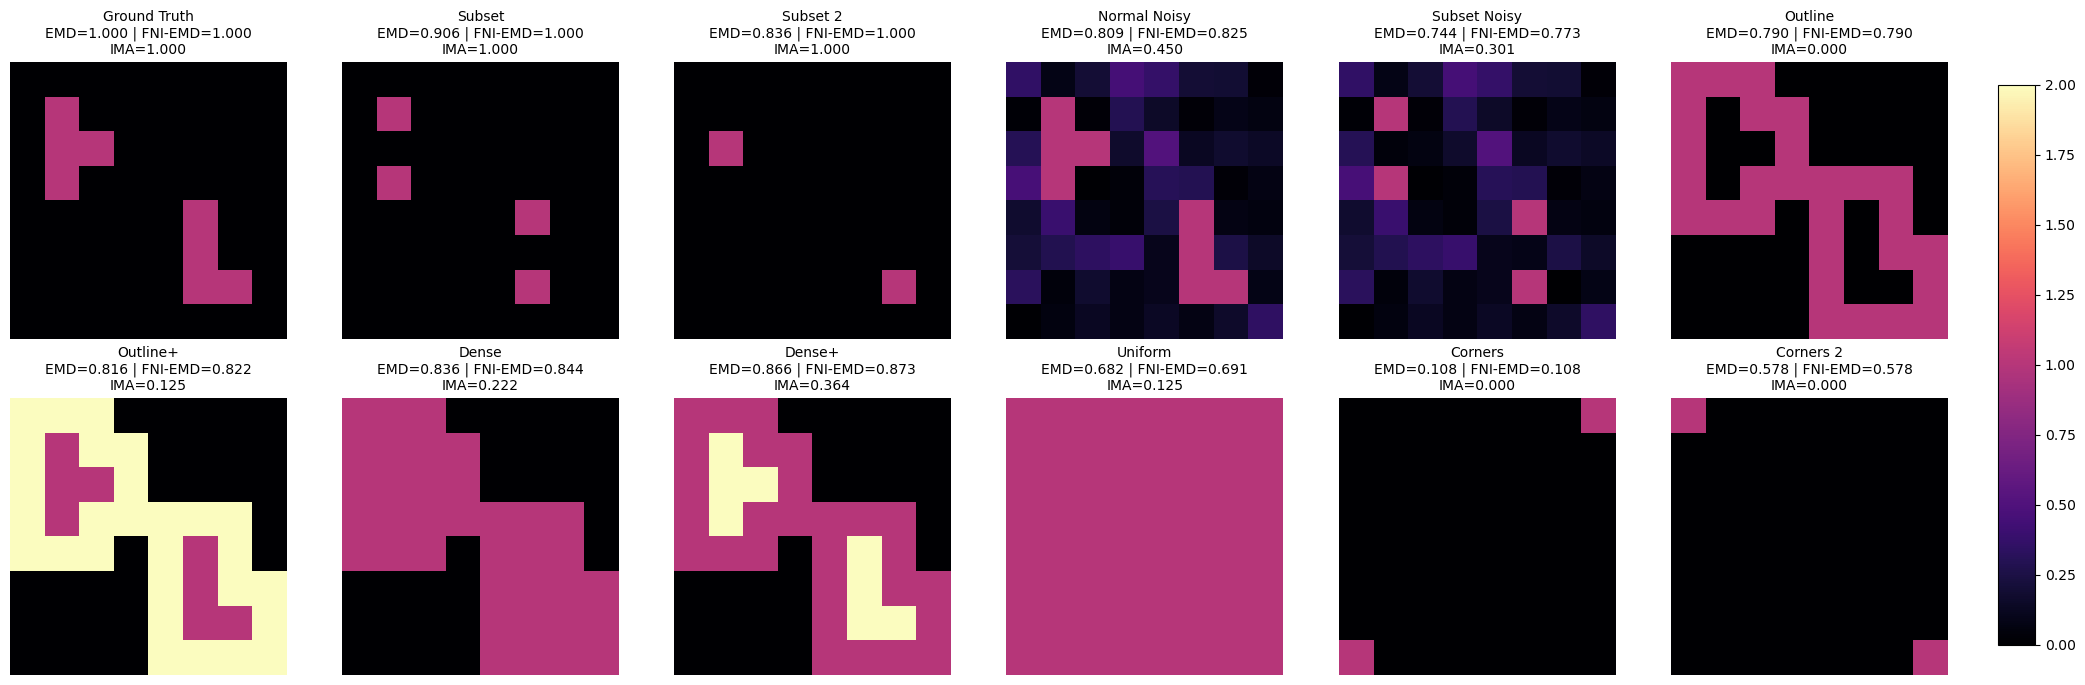

In [9]:

vmin = min(np.min(np.abs(exp)) for _, exp in explanations)
vmax = max(np.max(np.abs(exp)) for _, exp in explanations)

# Plotting
n = len(explanations)
cols = (n + 1) // 2
fig, axs = plt.subplots(2, cols, figsize=(4 * cols + 1, 8))
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # Shared colorbar axis

for idx, (name, expl_flat) in enumerate(explanations):
    emd_score = calculate_emd_score_metric(gt_flat, expl_flat, edge_length, cost_matrix, is_fni=False)
    fni_score = calculate_emd_score_metric(gt_flat, expl_flat, edge_length, cost_matrix, is_fni=True)
    ima_score = importance_mass_accuracy(gt_flat, expl_flat)

    ax = axs[idx // cols, idx % cols]
    im = ax.imshow(expl_flat.reshape((edge_length, edge_length)), cmap='magma', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"{name}\nEMD={emd_score:.3f} | FNI-EMD={fni_score:.3f}\nIMA={ima_score:.3f}", fontsize=10)

fig.colorbar(im, cax=cax)

plt.savefig('./figures/fni_emd_intuition.png', bbox_inches='tight')
plt.savefig('./figures/fni_emd_intuition_hires.png', bbox_inches='tight', dpi=300)

plt.show()

In [9]:
import pandas as pd

# Load CSV files
final_df = pd.read_csv('./linesearch_results_final.csv')
ebm_df = pd.read_csv('./linesearch_results_ebm.csv')
ksvm_df = pd.read_csv('./linesearch_results_ksvm.csv')

# Merge 'ebm' column based on keys
final_df = final_df.merge(
    ebm_df[['scenario', 'manip_type', 'snr_value', 'ebm']],
    on=['scenario', 'manip_type', 'snr_value'],
    how='left'
)

# merge 'kernel_svm' column based on keys
final_df = final_df.merge(
    ksvm_df[['scenario', 'manip_type', 'snr_value', 'kernel_svm']],
    on=['scenario', 'manip_type', 'snr_value'],
    how='left'
)

# Save merged result
final_df.to_csv('linesearch_results_merged.csv', index=False)
